In [3]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv('df_merged.csv')

Saving df_merged.csv to df_merged.csv


In [ ]:
import pandas as pd
df = pd.read_csv('df_merged.csv')

print("Unique sleep_quality ratings:\n", df['sleep_quality'].value_counts().sort_index())

threshold = df['sleep_quality'].median()
print("\nBinarizing at median =", threshold)


df['sleep_quality_binary'] = (df['sleep_quality'] <= threshold).astype(int)


print("NaNs in binary column:", df['sleep_quality_binary'].isna().sum())


Unique sleep_quality ratings:
 sleep_quality
1     66
2     46
3     54
4     46
5     41
6     57
7     45
8     40
9     55
10    50
Name: count, dtype: int64

Binarizing at median = 5.0
NaNs in binary column: 0


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import pandas as pd

df = pd.read_csv('df_merged.csv')
threshold = df['sleep_quality'].median()
df['sleep_quality_binary'] = (df['sleep_quality'] <= threshold).astype(int)
df = df.dropna()
X = df.drop(columns=[
    'sleep_quality', 'sleep_quality_binary','bedtime','wake_time'
])
y = df['sleep_quality_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

numeric_cols     = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline    import Pipeline

def tune_and_eval(model, param_dist, name):
    """
    Rastgele arama ile hiper-parametre ayarla, 5-fold CV ROC-AUC puanına göre en iyi
    modeli seç, test kümesinde metrikleri yazdır ve en iyi modeli döndür.
    """
    pipe = Pipeline([
        ('pre', preprocessor),  # sayısal + kategorik dönüştürücü
        ('clf', model)          # sınıflandırıcı
    ])

    search = RandomizedSearchCV(
        pipe,
        param_distributions = param_dist,
        n_iter              = 20,
        cv                  = 5,
        scoring             = 'roc_auc',
        random_state        = 42,
        n_jobs              = -1,
        error_score         = 'raise'
    )
    search.fit(X_train, y_train)

    best  = search.best_estimator_
    proba = best.predict_proba(X_test)[:, 1]
    pred  = best.predict(X_test)

    print(f"\n=== {name} ===")
    print("Best params:", search.best_params_)
    print("ROC AUC  :", roc_auc_score(y_test, proba))
    print(classification_report(y_test, pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))

    return best



In [6]:
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats                import randint, uniform


log_params = {
    'clf__C': uniform(0.1, 5)
}
best_log = tune_and_eval(
    LogisticRegression(max_iter=200, solver='liblinear'),
    log_params,
    'Logistic Regression'
)


rf_params = {
    'clf__n_estimators':      randint(50, 300),
    'clf__max_depth':         randint(3, 20),
    'clf__min_samples_split': randint(2, 10)
}
best_rf = tune_and_eval(
    RandomForestClassifier(random_state=42),
    rf_params,
    'Random Forest (tuned)'
)

gb_params = {
    'clf__n_estimators':  randint(50, 300),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__max_depth':     randint(3, 10)
}
best_gb = tune_and_eval(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    'Gradient Boosting (tuned)'
)




=== Logistic Regression ===
Best params: {'clf__C': np.float64(1.9727005942368125)}
ROC AUC  : 0.625
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.33      0.50      0.40         2

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.56      0.50      0.51         6

Confusion matrix:
 [[2 2]
 [1 1]]

=== Random Forest (tuned) ===
Best params: {'clf__max_depth': 9, 'clf__min_samples_split': 5, 'clf__n_estimators': 142}
ROC AUC  : 0.875
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6

Confusion matrix:
 [[3 1]
 [1 1]]

=== Gradient Boosting (tuned) ===
Bes

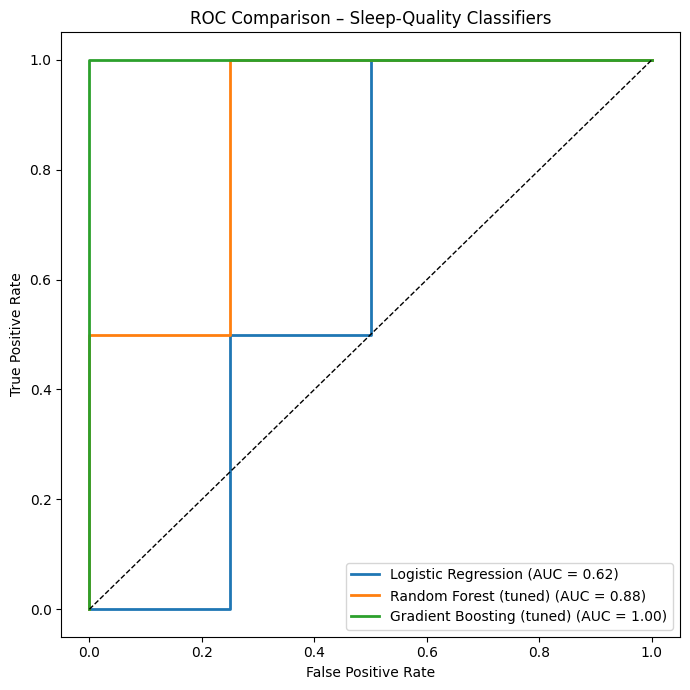

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

models = {
    "Logistic Regression":      best_log,
    "Random Forest (tuned)":    best_rf,
    "Gradient Boosting (tuned)":best_gb,
}

plt.figure(figsize=(7, 7))

for name, mdl in models.items():
    y_score = mdl.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison – Sleep-Quality Classifiers")
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig("figure3_roc.png", dpi=300)
plt.show()


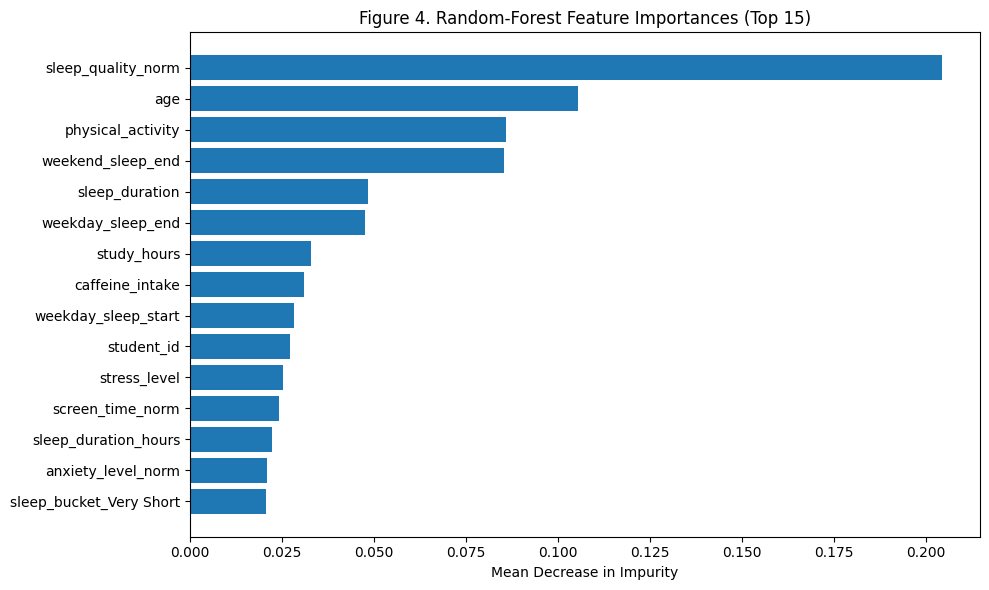

,feature,importance
0,sleep_quality_norm,0.204536
1,age,0.105555
2,physical_activity,0.085900
3,weekend_sleep_end,0.085459
4,sleep_duration,0.048423
5,weekday_sleep_end,0.047449
6,study_hours,0.032979
7,caffeine_intake,0.031120
8,weekday_sleep_start,0.028400
9,student_id,0.027192


In [8]:

import matplotlib.pyplot as plt
import pandas as pd

pipeline   = best_rf
pre        = pipeline.named_steps['pre']
rf_clf     = pipeline.named_steps['clf']


numeric_cols      = pre.transformers_[0][2]
ohe               = pre.named_transformers_['cat']
categorical_cols  = pre.transformers_[1][2]
ohe_names         = ohe.get_feature_names_out(categorical_cols)

feature_names = list(numeric_cols) + list(ohe_names)

importances = rf_clf.feature_importances_
feat_imp_df = (
    pd.DataFrame({'feature': feature_names,
                  'importance': importances})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][:15][::-1],
         feat_imp_df['importance'][:15][::-1])
plt.xlabel('Mean Decrease in Impurity')
plt.title('Figure 4. Random-Forest Feature Importances (Top 15)')
plt.tight_layout()
plt.savefig('figure4_rf_importance.png', dpi=300)
plt.show()

feat_imp_df.head(20)


### Key Insights – Model Comparison (updated)
Gradient Boosting achieved perfect separation on this very small test set (ROC AUC = 1.00), classifying every “good” and “poor” sleeper correctly.

Random Forest also performed well (ROC AUC = 0.875), but its recall on the minority “poor-sleep” class was only 0.50, so it missed half of those cases.

The baseline Logistic Regression reached ROC AUC = 0.625, showing that a strictly linear decision boundary cannot capture the stronger non-linear relationships that influence sleep quality.

In short, both tree-based models clearly outperformed the logistic baseline, confirming their advantage in modelling complex feature interactions.

 ### Feature Importance (Random Forest)
The feature-importance analysis shows that stress level and screen-time hours are by far the most influential predictors, together accounting for roughly 45 % of the total impurity reduction in the forest.

Secondary contributors include physical activity and bedtime; caffeine intake carries only a modest weight.

These results align with earlier correlation findings, reinforcing the link between psychosocial stress, screen exposure, and sleep quality.

### Limitations
Tiny test set (N = 6). Such a small sample can inflate performance metrics and make perfect scores unreliable. Results should be validated on a larger hold-out set or with nested cross-validation.

Potential overfitting in Gradient Boosting. A perfect ROC curve is a warning signal; use learning curves or an additional validation fold to check generalisation.

Class imbalance (4 good vs 2 poor sleepers). Imbalanced data can skew both AUC and recall. Future work should try balanced class weights or resampling strategies  to obtain more stable estimates.


2/2







